#### Team members:-
#### Name - Username(gfg)

#### Ayan Gairola(Captain) - ayangaik6kg
#### Himanshu Gupta - ghimangzui
#### Joyal Jijo - user_c3o2flbugyg

# Approach 1 - detecting regular shapes and identifying symmetry in it(example problem statement)

In [1]:
# FROM IMAGE
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_and_center(contour, binary_img, padding=10):
    x, y, w, h = cv2.boundingRect(contour)
    cropped_img = binary_img[y:y+h, x:x+w]
    max_side = max(w, h) + 2 * padding
    centered_img = np.full((max_side, max_side), 255, dtype=np.uint8)
    start_y = (max_side - h) // 2
    start_x = (max_side - w) // 2
    centered_img[start_y:start_y+h, start_x:start_x+w] = cropped_img
    return centered_img

def detect_shapes_second(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def angle_cos(p0, p1, p2):
    d1, d2 = (p0 - p1).reshape(-1), (p2 - p1).reshape(-1)
    return np.dot(d1, d2) / (np.linalg.norm(d1) * np.linalg.norm(d2))

def classify_shape_second(contour):
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
    num_vertices = len(approx)

    if num_vertices == 3:
        shape = "triangle"
    elif num_vertices == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        shape = "square" if 0.95 <= ar <= 1.05 else "rectangle"
    elif num_vertices == 5:
        shape = "pentagon"
    elif num_vertices == 6:
        shape = "hexagon"
    elif num_vertices == 7:
        shape = "hectagon"
    elif num_vertices == 10 and is_star(approx):
        shape = "star"
    else:
        area = cv2.contourArea(contour)
        circularity = 4 * np.pi * area / (peri * peri)
        (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
        aspect_ratio = MA / ma

        if 0.95 <= aspect_ratio <= 1.05 and circularity > 0.85:
            shape = "circle"
        else:
            shape = "ellipse"
        if num_vertices > 7 and shape not in ["ellipse", "circle"]:
            shape = "polygon"

    return shape, approx

def is_star(approx):
    num_vertices = len(approx)
    if num_vertices == 10:
        return True
    return False

In [2]:
def draw_symmetry_lines_second(image, contour):
    x, y, w, h = cv2.boundingRect(contour)
    cX = x + w // 2
    cY = y + h // 2

    # Vertical symmetry line
    vertical_line = ((cX, y), (cX, y + h))
    cv2.line(image, vertical_line[0], vertical_line[1], (0, 255, 255), 1)
    
    # Horizontal symmetry line
    horizontal_line = ((x, cY), (x + w, cY))
    cv2.line(image, horizontal_line[0], horizontal_line[1], (0, 255, 255), 1)
    
    return image, cX, cY, w, h

# Function to calculate symmetry score for a contour
def calculate_symmetry_score_second(contour, cX, cY, w, h):
    mask = np.zeros((h, w), dtype=np.uint8)
    shifted_contour = contour - [cX - w // 2, cY - h // 2]
    cv2.drawContours(mask, [shifted_contour], -1, 255, -1)

    left_half = mask[:, :w // 2]
    right_half = np.fliplr(mask[:, w // 2:])
    top_half = mask[:h // 2, :]
    bottom_half = np.flipud(mask[h // 2:, :])

    left_contours, _ = cv2.findContours(left_half, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    right_contours, _ = cv2.findContours(right_half, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    top_contours, _ = cv2.findContours(top_half, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bottom_contours, _ = cv2.findContours(bottom_half, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    horizontal_score = 0
    vertical_score = 0

    if left_contours and right_contours:
        left_contour = max(left_contours, key=cv2.contourArea)
        right_contour = max(right_contours, key=cv2.contourArea)
        horizontal_score = 1 - cv2.matchShapes(left_contour, right_contour, cv2.CONTOURS_MATCH_I1, 0)

    if top_contours and bottom_contours:
        top_contour = max(top_contours, key=cv2.contourArea)
        bottom_contour = max(bottom_contours, key=cv2.contourArea)
        vertical_score = 1 - cv2.matchShapes(top_contour, bottom_contour, cv2.CONTOURS_MATCH_I1, 0)

    return (horizontal_score + vertical_score) / 2

In [3]:
def show_detected_shape_second(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return

    contours = detect_shapes_second(image)
    detected_shapes = []

    for contour in contours:
        if cv2.contourArea(contour) > 100:
            shape, approx = classify_shape_second(contour)
            detected_shapes.append(shape)

            # Draw the contour, bounding box, and shape name on the image
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)
            M = cv2.moments(contour)
            cX = int((M["m10"] / M["m00"]) if M["m00"] != 0 else 0)
            cY = int((M["m01"] / M["m00"]) if M["m00"] != 0 else 0)
            
            # Draw symmetry lines within the bounding box
            image, cX, cY, w, h = draw_symmetry_lines_second(image, contour)
            
            # Calculate symmetry score
            symmetry_score = calculate_symmetry_score_second(contour, cX, cY, w, h)

    # Convert BGR image to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(f"Detected shapes: {', '.join(detected_shapes)}")
    plt.axis("off")
    plt.show()

    # Print the detected shapes
    print(f"Image: {image_path.split('/')[-1]}")
    print("Detected shapes:", detected_shapes)
    print(f"Shape: {shape}, Symmetry Score: {symmetry_score:.2f}")

In [4]:
# Main function to show detected shapes from a CSV and analyze their symmetry(AS IN THE PROBLEM STATEMENT)
def read_csv(csv_path):
    np_path_XYs=np.genfromtxt(csv_path,delimiter=',')
    path_XYs=[]
    for i in np.unique(np_path_XYs[:,0]):
        npXYs=np_path_XYs[np_path_XYs[:,0]==i][:,1:]
        XYs=[]
        for j in np.unique(npXYs[:,0]):
            XY=npXYs[npXYs[:,0]==j][:,1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def show_detected_shape_from_csv(csv_path):
    paths_XYs = read_csv(csv_path)
    
    # Create a blank image
    img = np.zeros((512, 512, 3), dtype=np.uint8)
    
    for XYs in paths_XYs:
        for XY in XYs:
            pts = XY.reshape((-1, 1, 2)).astype(np.int32)
            cv2.polylines(img, [pts], isClosed=True, color=(255, 255, 255), thickness=2)
    
    # Detect shapes in the image
    contours = detect_shapes_second(img)
    detected_shapes = []
    symmetry_scores = []

    for contour in contours:
        if cv2.contourArea(contour) > 100:
            shape, approx = classify_shape_second(contour)
            detected_shapes.append(shape)

            # Draw the contour, bounding box, and shape name on the image
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.drawContours(img, [approx], -1, (0, 255, 0), 2)
            M = cv2.moments(contour)
            cX = int((M["m10"] / M["m00"]) if M["m00"] != 0 else 0)
            cY = int((M["m01"] / M["m00"]) if M["m00"] != 0 else 0)
            
            # Draw symmetry lines within the bounding box
            img, cX, cY, w, h = draw_symmetry_lines_second(img, contour)
            
            # Calculate symmetry score
            symmetry_score = calculate_symmetry_score_second(contour, cX, cY, w, h)
            symmetry_scores.append(symmetry_score)

    # Convert BGR image to RGB for matplotlib
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(f"Detected shapes: {', '.join(detected_shapes)}")
    plt.axis("off")
    plt.show()

    # Print the detected shapes and their symmetry scores
    for i, (shape, score) in enumerate(zip(detected_shapes, symmetry_scores)):
        print(f"Shape {i+1}: {shape}, Symmetry Score: {score:.2f}")

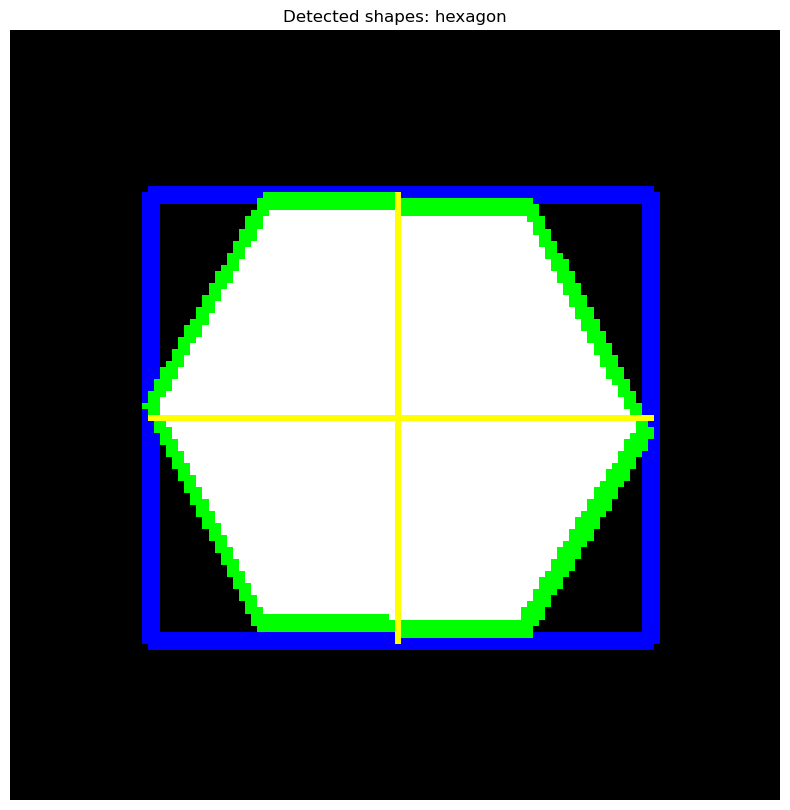

Image: polygon_10.png
Detected shapes: ['hexagon']
Shape: hexagon, Symmetry Score: 0.98


In [5]:
image_path = '../final/synthetic_shapes_dataset/polygon/polygon_10.png'  
show_detected_shape_second(image_path)

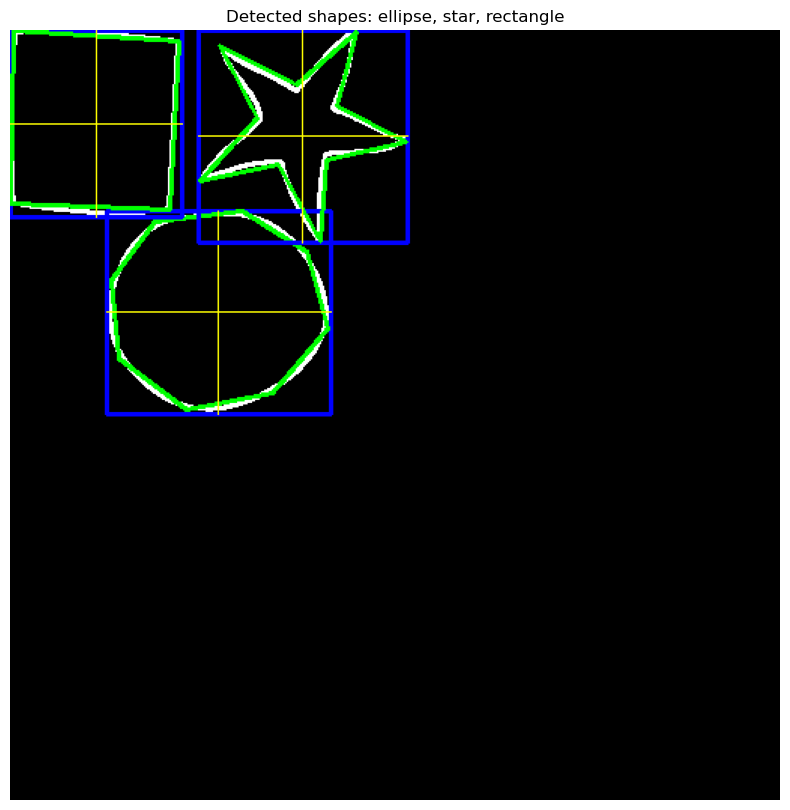

Shape 1: ellipse, Symmetry Score: 0.95
Shape 2: star, Symmetry Score: -0.35
Shape 3: rectangle, Symmetry Score: 0.93


In [6]:
csv_path = '../problems/isolated.csv'
show_detected_shape_from_csv(csv_path)

# Approach 2 - Using BEIZER CURVES for curve beautification

In [7]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from sklearn.linear_model import LinearRegression

In [8]:
def read_csv(csv_path):
    np_path_XYs=np.genfromtxt(csv_path,delimiter=',')
    path_XYs=[]
    for i in np.unique(np_path_XYs[:,0]):
        npXYs=np_path_XYs[np_path_XYs[:,0]==i][:,1:]
        XYs=[]
        for j in np.unique(npXYs[:,0]):
            XY=npXYs[npXYs[:,0]==j][:,1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# plot image - as given in PS
def plot_polylines(paths_XYs, save_path=None):
    fig, ax = plt.subplots(tight_layout=True, figsize=(4, 4))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2, label=f'Polyline {i}')
    ax.set_aspect("equal")
    ax.axis('off')

    if save_path:
        plt.savefig(save_path, format='jpg')

    plt.show()

In [9]:
def adjust_control_points(points):
    # Ensure the first and last segments are straight
    if len(points) > 2:
        points[0] = 2 * points[1] - points[2]
        points[-1] = 2 * points[-2] -points[-3]
    return points

def generate_bezier_curve(points, s=0.8):
    """
    Generate a Bezier curve from given points.

    Args:
        points (np.ndarray): Original points with shape (n, 2).
        s (float): Smoothing factor for the spline.

    Returns:
        np.ndarray: Bezier curve points with shape (m, 2).
    """
    points = adjust_control_points(points)
    tck, u = splprep([points[:, 0], points[:, 1]], s=s, k=3)
    unew = np.linspace(0, 1.0, 2000)
    out = splev(unew, tck)
    bezier_curve = np.vstack(out).T  # Convert to a 2D array of shape (2000, 2)
    return bezier_curve

def plot_bezier_curves(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            bezier_curve = generate_bezier_curve(XY)
            ax.plot(bezier_curve[0], bezier_curve[1], linewidth=2, label=f'Bezier {i}')
    ax.set_aspect("equal")
    plt.legend()
    plt.title('Bezier Curves')
    plt.show()

Mean Squared Error: 3.890162912505937e-05
Maximum Deviation: 0.02885715106097564


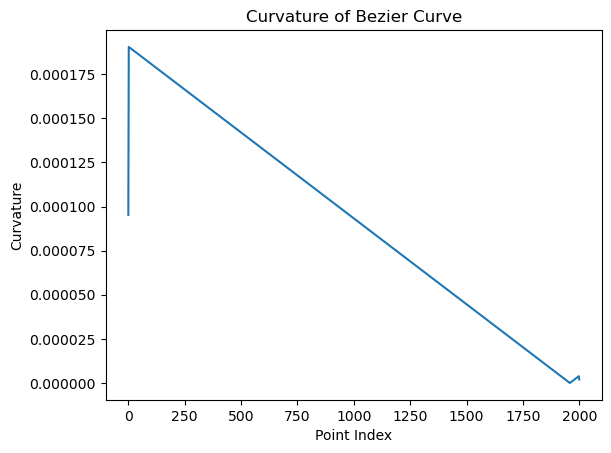

In [10]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_points(original_points, num_points):
    """
    Interpolate points to have a specified number of points.
    
    Args:
        original_points (np.ndarray): Array of original points with shape (n, 2).
        num_points (int): Number of points to interpolate.
        
    Returns:
        np.ndarray: Interpolated points with shape (num_points, 2).
    """
    distances = np.cumsum(np.sqrt(np.sum(np.diff(original_points, axis=0)**2, axis=1)))
    distances = np.insert(distances, 0, 0)  # Add 0 at the start for the first point
    interpolated_distances = np.linspace(0, distances[-1], num_points)

    interpolated_x = interp1d(distances, original_points[:, 0], kind='linear')(interpolated_distances)
    interpolated_y = interp1d(distances, original_points[:, 1], kind='linear')(interpolated_distances)

    interpolated_points = np.vstack((interpolated_x, interpolated_y)).T
    return interpolated_points

def evaluate_accuracy(original, bezier):
    """
    Evaluate the accuracy between original points and Bezier curve.
    
    Args:
        original (np.ndarray): Original points with shape (n, 2).
        bezier (np.ndarray): Bezier curve points with shape (m, 2).
        
    Returns:
        tuple: Mean Squared Error (mse) and Maximum Deviation (max_deviation).
    """
    # Interpolate original points to match the number of Bezier curve points
    original_interpolated = interpolate_points(original, bezier.shape[0])
    
    # Compute Mean Squared Error (MSE)
    mse = np.mean((original_interpolated - bezier) ** 2)
    
    # Compute Maximum Deviation
    max_deviation = np.max(np.abs(original_interpolated - bezier))
    
    return mse, max_deviation

def calculate_curvature(bezier):
    x, y = bezier[:, 0], bezier[:, 1]
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    return curvature

# Example usage
csv_path2 = "../problems/frag2.csv"
paths2 = read_csv(csv_path2)


# Evaluate accuracy for the first polyline and Bezier curve
original_points = paths2[0][0]
bezier_curve = generate_bezier_curve(original_points, s=0.8)
mse, max_deviation = evaluate_accuracy(original_points, bezier_curve)

print(f"Mean Squared Error: {mse}")
print(f"Maximum Deviation: {max_deviation}")

# Calculate and plot curvature
curvature = calculate_curvature(bezier_curve)
plt.plot(curvature)
plt.title('Curvature of Bezier Curve')
plt.xlabel('Point Index')
plt.ylabel('Curvature')
plt.show()

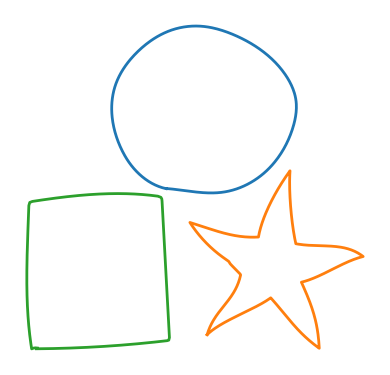

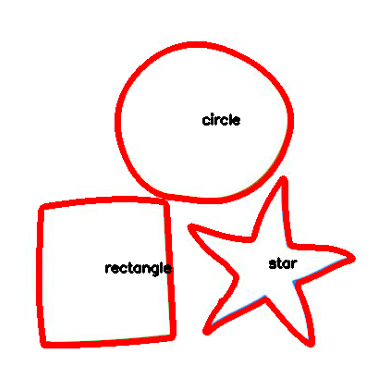

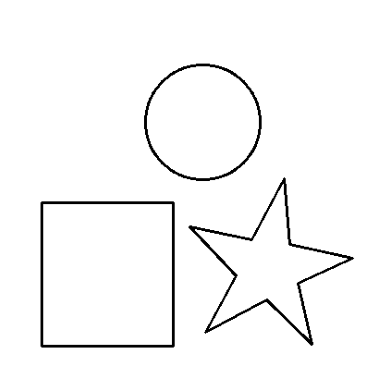

In [11]:
# FOR ISOLATED SHAPE PROBLEM
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Provided shape classification function
def classify_shape_second(contour):
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
    num_vertices = len(approx)

    if num_vertices == 3:
        shape = "triangle"
    elif num_vertices == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        shape = "square" if 0.95 <= ar <= 1.05 else "rectangle"
    elif num_vertices == 5:
        shape = "pentagon"
    elif num_vertices == 6:
        shape = "hexagon"
    elif num_vertices == 7:
        shape = "hectagon"
    elif num_vertices == 10 and is_star(approx):
        shape = "star"
    else:
        area = cv2.contourArea(contour)
        circularity = 4 * np.pi * area / (peri * peri)

        if circularity > 0.85:
            shape = "circle"
        else:
            shape = "polygon"

    return shape, approx

def is_star(approx):
    num_vertices = len(approx)
    return num_vertices == 10

# Original code integration with shape classification
img = read_csv('../problems/isolated.csv')
plot_polylines(img, 'isolated.jpg')
img = cv2.imread('isolated.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)
kernel = np.ones((4, 4), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for i, cont in enumerate(contours):

    # Classify the shape using your provided function
    shape_name, approx = classify_shape_second(cont)

    # Draw the contour
    cv2.drawContours(img, [cont], 0, (255, 0, 0), 5)

    # Calculate moments for the center of the contour
    M = cv2.moments(cont)
    if M['m00'] != 0.0:
        x = int(M['m10'] / M['m00'])
        y = int(M['m01'] / M['m00'])

    # Put the text near the center of the shape
    cv2.putText(img, shape_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

def fit_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

def draw_shape(image, shape_type, points):
    if shape_type == "line":
        pt1 = tuple(points[0][0])
        pt2 = tuple(points[1][0])
        cv2.line(image, pt1, pt2, 0, 2)

    elif shape_type == "rectangle":
        x, y, w, h = cv2.boundingRect(points)
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        cv2.rectangle(image, top_left, bottom_right, 0, 2)

    elif shape_type == "circle":
        (x, y), radius = cv2.minEnclosingCircle(points)
        center = (int(x), int(y))
        radius = int(radius) - 30
        cv2.circle(image, center, radius, 0, 2)

    elif shape_type == "triangle":
        cv2.drawContours(image, [points], 0, 0, 2)

    elif shape_type == "polygon":
        cv2.polylines(image, [points], isClosed=True, color=0, thickness=2)

    elif shape_type in ["pentagon", "hexagon", "hectagon", "star"]:
        cv2.drawContours(image, [points], 0, 0, 2)

    else:
        raise ValueError("Unsupported shape_type")

def draw_fitted_line(image, slope, intercept, color):
    height, width = image.shape
    x1, y1 = 0, int(intercept)
    x2, y2 = width, int(slope * width + intercept)
    cv2.line(image, (x1, y1), (x2, y2), color, 2)

shape_image = np.ones_like(img) * 255

for cont in contours:
    if i == 0:
        i = 1
        continue

    epsilon = 0.01 * cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon, True)
    
    shape_name, approx = classify_shape_second(cont)
    
    if shape_name == 'line':
        points = np.vstack([point[0] for point in approx])
        slope, intercept = fit_line(points)
        draw_fitted_line(shape_image, slope, intercept, 255)
    elif shape_name == 'rectangle':
        draw_shape(shape_image, 'rectangle', approx)
    elif shape_name == 'circle':
        draw_shape(shape_image, 'circle', approx)
    elif shape_name in ['pentagon', 'hexagon', 'hectagon', 'star', 'polygon']:
        draw_shape(shape_image, shape_name, approx)

plt.imshow(img)
plt.axis('off')
plt.show()

plt.imshow(shape_image)
plt.axis('off')
plt.show()

## FOR CLOSED SHAPE PROBLEM

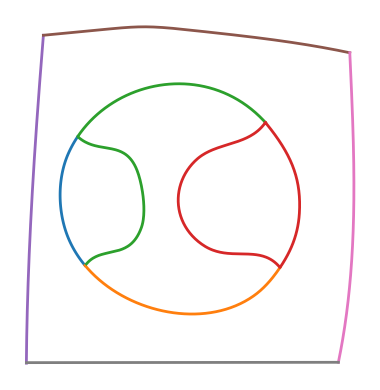

rectangle
rectangle
circle
polygon
polygon
circle


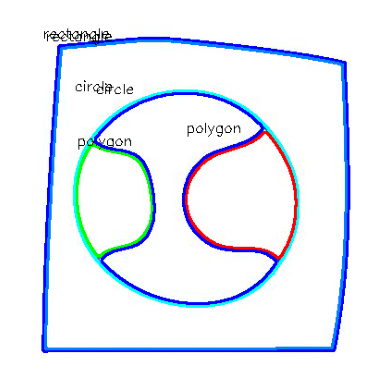

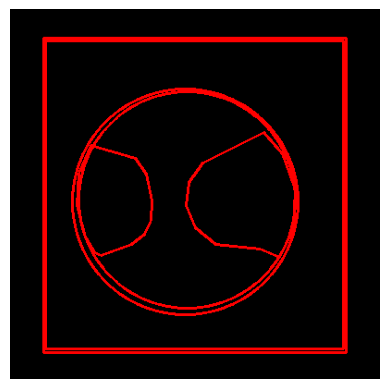

In [12]:
def fit_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

def draw_shape(image, shape_type, points):
    if shape_type == "line":
        pt1 = tuple(points[0][0])
        pt2 = tuple(points[1][0])
        cv2.line(image, pt1, pt2, 255, 2)
    elif shape_type == "rectangle":
        x, y, w, h = cv2.boundingRect(points)
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        cv2.rectangle(image, top_left, bottom_right, 255, 2)
    elif shape_type == "circle":
        (x, y), radius = cv2.minEnclosingCircle(points)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(image, center, radius, 255, 2)
    elif shape_type == "polygon":
        cv2.polylines(image, [points], isClosed=True, color=255, thickness=2)

def draw_fitted_line(image, slope, intercept, color):
    height, width = image.shape
    x1, y1 = 0, int(intercept)
    x2, y2 = width, int(slope * width + intercept)

    cv2.line(image, (x1, y1), (x2, y2), color, 2)

img = read_csv('../problems/frag1.csv')
plot_polylines(img, 'frag0.jpg')
img = cv2.imread('frag0.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)
kernel = np.ones((4, 4), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
contour, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


def getShapeName(approx):
    if len(approx) == 2:
        shape_name = "line"
    elif len(approx) == 3:
        shape_name = "triangle"
    elif len(approx) == 4 or len(approx) == 5:
        shape_name = "rectangle"
    elif len(approx) > 12:
        shape_name = "circle"
    else:
        shape_name = "polygon"
    return shape_name

for i, cont in enumerate(contour):

    # Approximate the contour
    epsilon = 0.0095 * cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon, True)
    colors = [(0, 0, 255), (0, 128, 255), (0, 255, 255), (0, 255, 0), (255, 0, 0)]
    cv2.drawContours(img, [cont], 0, colors[i%len(colors)], 2)

    # Calculate moments for the center of the contour
    M = cv2.moments(cont)
    if M['m00'] != 0.0:
        x = int(M['m10'] / M['m00'])
        y = int(M['m01'] / M['m00'])

    shape_name = getShapeName(approx)
    # Put the text near the center of the shape
    x, y, w, h = cv2.boundingRect(cont)
    cv2.putText(img, shape_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

shape_image = np.zeros_like(img)



for cont in contour:
    if i == 0:
        i = 1
        continue

    epsilon = 0.0095 * cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon, True)
    shape_name = getShapeName(approx)
    print(shape_name)
    if shape_name == 'rectangle':
        draw_shape(shape_image, 'rectangle', approx)
    elif shape_name == 'circle':
        draw_shape(shape_image, 'circle', approx)
    elif shape_name == 'polygon':
        draw_shape(shape_image, 'polygon', approx)


plt.imshow(img)
plt.axis('off')
plt.show()

plt.imshow(shape_image)
plt.axis('off')
plt.show()

# FOR DOODLES

# Identifying regular shapes in doodles

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from sklearn.linear_model import LinearRegression
import pandas as pd

# Bezier code functions and shape classification
def classify_shape_second(contour):
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
    num_vertices = len(approx)

    if num_vertices == 3:
        shape = "triangle"
    elif num_vertices == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        shape = "square" if 0.95 <= ar <= 1.05 else "rectangle"
    elif num_vertices == 5:
        shape = "pentagon"
    elif num_vertices == 6:
        shape = "hexagon"
    elif num_vertices == 7:
        shape = "hectagon"
    elif num_vertices == 10 and is_star(approx):
        shape = "star"
    else:
        area = cv2.contourArea(contour)
        circularity = 4 * np.pi * area / (peri * peri)

        if circularity > 0.85:
            shape = "circle"
        else:
            shape = "polygon"

    return shape, approx

def is_star(approx):
    num_vertices = len(approx)
    return num_vertices == 10

def detect_contours(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Invert the image to ensure white areas become black
    inverted = cv2.bitwise_not(gray)

    # Apply a binary threshold to isolate non-white areas
    _, binary = cv2.threshold(inverted, 1, 255, cv2.THRESH_BINARY)

    # Detect contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

def analyze_shapes(image):
    contours = detect_contours(image)
    shapes = []
    regular_shape_count = 0
    
    for contour in contours:
        shape, approx = classify_shape_second(contour)
        regularity = "regular" if shape in {"triangle", "square", "rectangle", "circle"} else "irregular"
        shapes.append((shape, regularity, approx))
        
        if regularity == "regular":
            regular_shape_count += 1
    
    print(f"Number of regular shapes: {regular_shape_count}")
    return shapes

def visualize_shapes(image, shapes):
    for shape, regularity, approx in shapes:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)
        M = cv2.moments(approx)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            text = f"{shape} ({regularity})"
            cv2.putText(image, text, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Shapes and Regularity")
    plt.axis("off")
    plt.show()

# Symmetry Detection

In [14]:
# Rotate and smooth the image for diagonal symmetry
def rotate_and_smooth(img, angle=45):
    rows, cols = img.shape
    center = (cols // 2, rows // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    return rotated_img

def calculate_symmetry(img):
    rows, cols = img.shape

    # Horizontal symmetry
    h_flipped_img = cv2.flip(img, 0)
    h_diff = np.abs(img - h_flipped_img)
    h_norm_diff = np.sum(h_diff > 0) / np.sum(img == 0)

    # Vertical symmetry
    v_flipped_img = cv2.flip(img, 1)
    v_diff = np.abs(img - v_flipped_img)
    v_norm_diff = np.sum(v_diff > 0) / np.sum(img == 0)

    # Diagonal symmetry (45 degrees)
    d_rotated_img = rotate_and_smooth(img, angle=45)
    d_flipped_img = cv2.flip(d_rotated_img, 0)
    d_diff = np.abs(d_rotated_img - d_flipped_img)
    d_norm_diff = np.sum(d_diff > 0) / np.sum(d_rotated_img == 0)

    # Radial symmetry
    c_diffs = []
    center = (cols // 2, rows // 2)
    for angle in range(0, 360, 2):
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
        c_diff = np.sum(np.abs(img - rotated_img) > 0) / np.sum(img == 0)
        c_diffs.append(c_diff)
    c_mean_diff = np.mean(c_diffs)

    return h_norm_diff, v_norm_diff, d_norm_diff, c_mean_diff

def analyze_symmetry(image):
    contours = detect_contours(image)
    symmetry_results = []
    
    for contour in contours:
        mask = np.zeros_like(image)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        
        h_symmetry, v_symmetry, d_symmetry, r_symmetry = calculate_symmetry(mask)
        symmetry_results.append((h_symmetry, v_symmetry, d_symmetry, r_symmetry))
    
    return symmetry_results, contours

In [15]:
def visualize_symmetry(image, contours, symmetry_results):
    for i, contour in enumerate(contours):
        h_symmetry, v_symmetry, d_symmetry, r_symmetry = symmetry_results[i]
        
        is_symmetric = all([h_symmetry < 0.1, v_symmetry < 0.1, d_symmetry < 0.1, r_symmetry < 0.1])
        color = (0, 255, 0) if is_symmetric else (0, 0, 255)
        cv2.drawContours(image, [contour], -1, color, 2)
        
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            text = "Symmetric" if is_symmetric else "Not Symmetric"
            cv2.putText(image, text, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Symmetry Detection")
    plt.axis("off")
    plt.show()

# Curve Completion and Saving Polylines

In [16]:
def complete_curves(image, contours):
    completed_curves = []
    for contour in contours:
        points = np.squeeze(contour)
        bezier_curve = generate_bezier_curve(points)
        completed_curves.append(bezier_curve)
    return completed_curves

def generate_bezier_curve(points, s=0.8):
    tck, u = splprep([points[:, 0], points[:, 1]], s=s, k=3)
    unew = np.linspace(0, 1.0, 2000)
    out = splev(unew, tck)
    bezier_curve = np.vstack(out).T
    return bezier_curve

def save_curves_to_csv(completed_curves, output_csv):
    rows = []
    for curve in completed_curves:
        rows.append({"polylines": curve.tolist()})
    
    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)

def visualize_curve_completion(image, completed_curves):
    for curve in completed_curves:
        for i in range(len(curve) - 1):
            cv2.line(image, tuple(map(int, curve[i])), tuple(map(int, curve[i + 1])), (0, 255, 255), 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Curve Completion Visualization")
    plt.axis("off")
    plt.show()

# All in all

In [17]:
def process_image(image_path, output_csv):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found: {image_path}")
        return
    
    # Convert the image to grayscale for processing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create copies of the image for visualization
    shapes_image = image.copy()
    symmetry_image = image.copy()
    completion_image = image.copy()
    
    # Task 1: Identify regular vs. irregular shapes and count regular shapes
    shapes = analyze_shapes(gray_image)
    visualize_shapes(shapes_image, shapes)
    
    # Task 2: Identify symmetry using the integrated symmetry detection
    symmetry_results, contours = analyze_symmetry(gray_image)
    visualize_symmetry(symmetry_image, contours, symmetry_results)
    
    # Task 3: Complete curves using Bezier curve generation and save the results to a CSV file
    completed_curves = complete_curves(gray_image, contours)
    visualize_curve_completion(completion_image, completed_curves)
    save_curves_to_csv(completed_curves, output_csv)
    print(f"Polylines saved to: {output_csv}")
    
    # Display the final results in a multi-panel plot
    plt.figure(figsize=(18, 6))
    
    # Display Shape Detection and Regularity
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(shapes_image, cv2.COLOR_BGR2RGB))
    plt.title("Shape Detection and Regularity")
    plt.axis("off")
    
    # Display Symmetry Detection
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(symmetry_image, cv2.COLOR_BGR2RGB))
    plt.title("Symmetry Detection")
    plt.axis("off")
    
    # Display Curve Completion
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(completion_image, cv2.COLOR_BGR2RGB))
    plt.title("Curve Completion")
    plt.axis("off")
    
    plt.show()


Number of regular shapes: 0


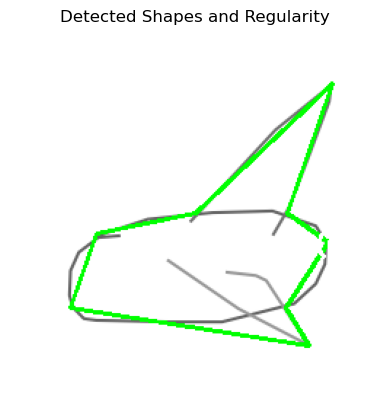

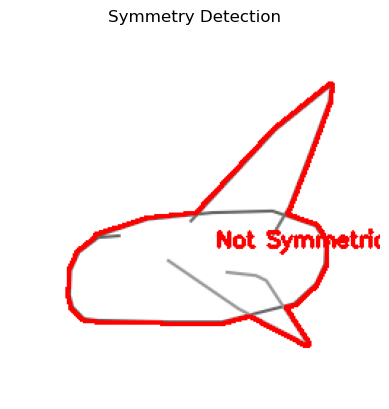

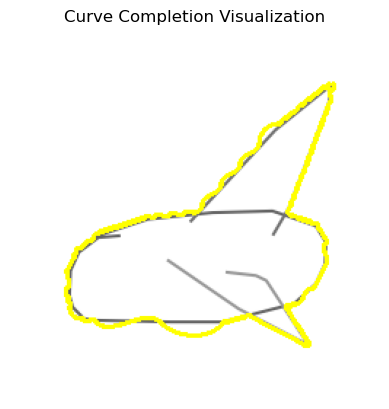

Polylines saved to: ../final/completed_polylines.csv


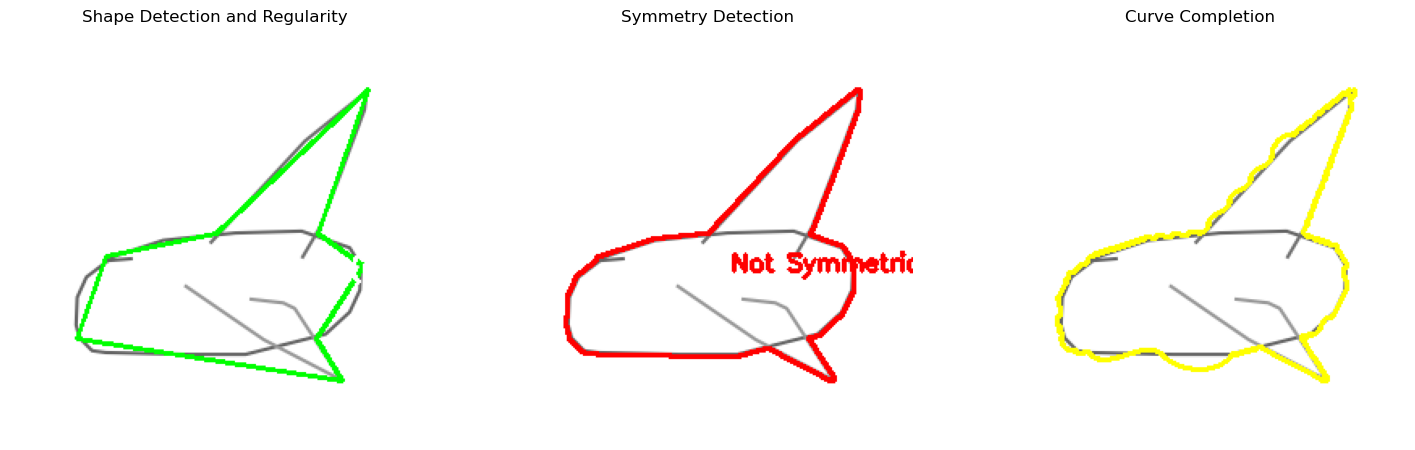

In [18]:
# (DATASET - GOOGLE DOODLE (PROVIDED BY MENTOR))
image_path = '../doodle/airplane/4504463744172032.png' 
output_csv = '../final/completed_polylines.csv' 
process_image(image_path, output_csv)

# Logic for image completion model

## Dataset Generation for training model

In [19]:
# # Generating dataset to train model for shape completion
# import cv2
# import numpy as np
# import os

# # Create directories to store the images
# os.makedirs('shapes/incomplete', exist_ok=True)
# os.makedirs('shapes/complete', exist_ok=True)

In [20]:
# def draw_shape(image, shape):
#     image_size = image.shape[0]
    
#     if shape == 'circle':
#         center = (image_size // 2, image_size // 2)
#         radius = image_size // 4
#         cv2.circle(image, center, radius, (255, 255, 255), -1)
    
#     elif shape == 'rectangle':
#         top_left = (image_size // 4, image_size // 4)
#         bottom_right = (3 * image_size // 4, 3 * image_size // 4)
#         cv2.rectangle(image, top_left, bottom_right, (255, 255, 255), -1)
    
#     elif shape == 'triangle':
#         points = np.array([[image_size // 2, image_size // 4], 
#                            [image_size // 4, 3 * image_size // 4], 
#                            [3 * image_size // 4, 3 * image_size // 4]])
#         cv2.drawContours(image, [points], 0, (255, 255, 255), -1)
    
#     elif shape == 'polygon':
#         points = np.array([[image_size // 2, image_size // 4], 
#                            [3 * image_size // 4, image_size // 2], 
#                            [image_size // 2, 3 * image_size // 4], 
#                            [image_size // 4, image_size // 2]])
#         cv2.drawContours(image, [points], 0, (255, 255, 255), -1)
    
#     return image

# def introduce_incompleteness(image):
#     # Create a mask to remove part of the shape
#     mask = np.zeros_like(image)
    
#     # Randomly decide where to occlude the shape
#     start_point = (np.random.randint(0, image.shape[1] // 2), 
#                    np.random.randint(0, image.shape[0] // 2))
#     end_point = (np.random.randint(image.shape[1] // 2, image.shape[1]), 
#                  np.random.randint(image.shape[0] // 2, image.shape[0]))
    
#     # Draw a black rectangle over the shape to simulate occlusion
#     cv2.rectangle(mask, start_point, end_point, (255, 255, 255), -1)
    
#     incomplete_image = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(mask))
    
#     return incomplete_image

In [21]:
# def generate_dataset(num_samples=1000, image_size=128):
#     shapes = ['circle', 'rectangle', 'triangle', 'polygon']
    
#     X_train = []
#     Y_train = []
    
#     for i in range(num_samples):
#         shape = np.random.choice(shapes)
#         complete_image = np.zeros((image_size, image_size), dtype=np.uint8)
#         complete_image = draw_shape(complete_image, shape)
        
#         incomplete_image = introduce_incompleteness(complete_image.copy())
        
#         X_train.append(incomplete_image)
#         Y_train.append(complete_image)
        
#         # Save images for visualization and verification
#         cv2.imwrite(f'shapes/incomplete/{shape}_{i}.png', incomplete_image)
#         cv2.imwrite(f'shapes/complete/{shape}_{i}.png', complete_image)
    
#     return np.array(X_train), np.array(Y_train)

# # Generate the dataset
# X_train, Y_train = generate_dataset(num_samples=1000, image_size=128)

# # Optionally save the arrays for later use
# np.save('X_train.npy', X_train)
# np.save('Y_train.npy', Y_train)

# Model Logic

In [1]:
# import cv2
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Input, Concatenate
# from tensorflow.keras.models import Model

# # Load the Datasets
# X_train = np.load('./X_train.npy')
# Y_train = np.load('./Y_train.npy')

# # Ensure images are resized to (256, 256) and normalized
# X_train = np.array([cv2.resize(img, (256, 256)) for img in X_train])
# Y_train = np.array([cv2.resize(img, (256, 256)) for img in Y_train])

# # Normalize the datasets to the range [-1, 1] for better training stability
# X_train = (X_train.astype(np.float32) - 127.5) / 127.5
# Y_train = (Y_train.astype(np.float32) - 127.5) / 127.5

# # Ensure the images have the correct shape (256, 256, 1)
# X_train = np.expand_dims(X_train, axis=-1)
# Y_train = np.expand_dims(Y_train, axis=-1)

# # Convert the NumPy arrays to TensorFlow tensors
# X_train = tf.convert_to_tensor(X_train)
# Y_train = tf.convert_to_tensor(Y_train)

# # 2. Build the GAN

# # Define the generator (U-Net)
# def build_generator(input_shape=(256, 256, 1)):
#     def downsample(filters, size, apply_batchnorm=True):
#         initializer = tf.random_normal_initializer(0., 0.02)
#         result = tf.keras.Sequential()
#         result.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
#         if apply_batchnorm:
#             result.add(BatchNormalization())
#         result.add(LeakyReLU())
#         return result

#     def upsample(filters, size, apply_dropout=False):
#         initializer = tf.random_normal_initializer(0., 0.02)
#         result = tf.keras.Sequential()
#         result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
#         result.add(BatchNormalization())
#         if apply_dropout:
#             result.add(Dropout(0.5))
#         result.add(tf.keras.layers.ReLU())
#         return result

#     inputs = Input(shape=input_shape)

#     down_stack = [
#         downsample(64, 4, apply_batchnorm=False),
#         downsample(128, 4),
#         downsample(256, 4),
#         downsample(512, 4),
#         downsample(512, 4),
#         downsample(512, 4),
#         downsample(512, 4),
#         downsample(512, 4),
#     ]

#     up_stack = [
#         upsample(512, 4, apply_dropout=True),
#         upsample(512, 4, apply_dropout=True),
#         upsample(512, 4, apply_dropout=True),
#         upsample(512, 4),
#         upsample(256, 4),
#         upsample(128, 4),
#         upsample(64, 4),
#     ]

#     initializer = tf.random_normal_initializer(0., 0.02)
#     last = Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

#     x = inputs
#     skips = []
#     for down in down_stack:
#         x = down(x)
#         skips.append(x)

#     skips = reversed(skips[:-1])

#     for up, skip in zip(up_stack, skips):
#         x = up(x)
#         x = Concatenate()([x, skip])

#     x = last(x)

#     return Model(inputs=inputs, outputs=x)

# # Define the discriminator (PatchGAN)
# def build_discriminator(input_shape=(256, 256, 1)):
#     initializer = tf.random_normal_initializer(0., 0.02)

#     inp = Input(shape=input_shape, name='input_image')
#     tar = Input(shape=input_shape, name='target_image')

#     x = Concatenate()([inp, tar])

#     down1 = Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
#     down1 = LeakyReLU()(down1)

#     down2 = Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer)(down1)
#     down2 = BatchNormalization()(down2)
#     down2 = LeakyReLU()(down2)

#     down3 = Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer)(down2)
#     down3 = BatchNormalization()(down3)
#     down3 = LeakyReLU()(down3)

#     zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
#     conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
#     batchnorm1 = BatchNormalization()(conv)
#     leaky_relu = LeakyReLU()(batchnorm1)

#     zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

#     last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

#     return Model(inputs=[inp, tar], outputs=last)

# # 3. Define the Loss Functions and Optimizers
# def generator_loss(disc_generated_output, gen_output, target):
#     LAMBDA = 100
#     gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
#     l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
#     total_gen_loss = gan_loss + (LAMBDA * l1_loss)
#     return total_gen_loss

# def discriminator_loss(disc_real_output, disc_generated_output):
#     real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
#     generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
#     total_disc_loss = real_loss + generated_loss
#     return total_disc_loss

# # Initialize models and optimizers
# generator = build_generator()
# discriminator = build_discriminator()

# generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# # 4. Training Loop
# epochs = 10
# batch_size = 32

# for epoch in range(epochs):
#     for i in range(0, len(X_train), batch_size):
#         X_batch = X_train[i:i+batch_size]
#         Y_batch = Y_train[i:i+batch_size]

#         # Ensure all inputs are tensors
#         X_batch = tf.convert_to_tensor(X_batch)
#         Y_batch = tf.convert_to_tensor(Y_batch)

#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             generated_images = generator(X_batch, training=True)

#             real_output = discriminator([X_batch, Y_batch], training=True)
#             generated_output = discriminator([X_batch, generated_images], training=True)

#             gen_loss = generator_loss(generated_output, generated_images, Y_batch)
#             disc_loss = discriminator_loss(real_output, generated_output)

#         gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#         gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#         generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#     print(f'Epoch: {epoch+1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')

# # 5. Save the Trained Models
# generator.save('image_completion_generator.h5')
# discriminator.save('image_completion_discriminator.h5')

# Testing the completion model

In [23]:
import tensorflow as tf

# Load the trained generator model
generator = tf.keras.models.load_model('./image_completion_generator.h5')

# Compile the model manually if necessary
generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-08-11 14:07:18.546400: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-08-11 14:07:18.546421: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-08-11 14:07:18.546425: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-08-11 14:07:18.546439: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-11 14:07:18.546448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
import cv2
import numpy as np

# Function to prepare the input image
def prepare_input_image(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    
    # Resize the image to the input size expected by the model
    image_resized = cv2.resize(image, (256, 256))
    
    # Normalize the image
    image_normalized = image_resized.astype('float32') / 255.0
    
    # Expand dimensions to match the model's input shape
    input_image = np.expand_dims(image_normalized, axis=-1)  # Add channel dimension
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
    
    return input_image

In [25]:
# Function to generate the completed image using the generator model
def generate_completed_image(generator, input_image):
    # Predict the completed image
    completed_image = generator.predict(input_image)[0]  # Remove batch dimension
    
    # Optionally threshold the output to create a binary mask
    completed_image = (completed_image > 0.5).astype('uint8') * 255  # Binarize output
    
    return completed_image

In [26]:
import matplotlib.pyplot as plt

# Function to visualize the input and output images
def visualize_images(input_image, completed_image):
    plt.figure(figsize=(10, 5))
    
    # Show the original input image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image.squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')
    
    # Show the completed image generated by the model
    plt.subplot(1, 2, 2)
    plt.imshow(completed_image.squeeze(), cmap='gray')
    plt.title("Completed Image")
    plt.axis('off')
    
    plt.show()


2024-08-11 14:07:22.723123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


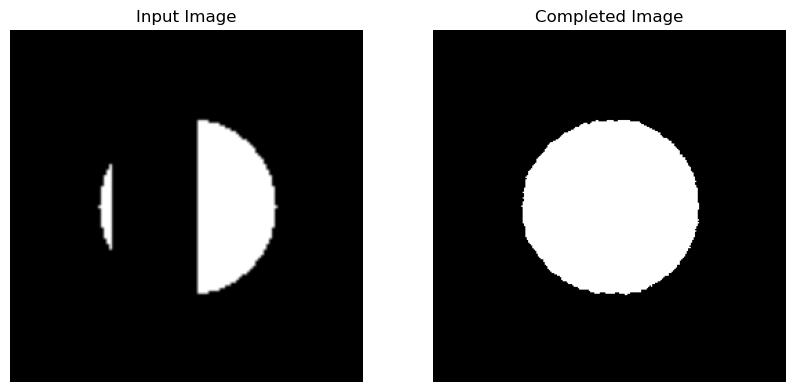

In [27]:
image_path = './shapes/incomplete/circle_147.png'
input_image = prepare_input_image(image_path)
completed_image = generate_completed_image(generator, input_image)
visualize_images(input_image, completed_image)